<img src="download.png" align="upper left" width="50%"> <img src="f6f926fba978ffa5b9e50f82e74ac8dc.jpg" align="lower left" width="30%">

## Objective - Method of prediction of WO's Overdues and Deferrals based on WO Dataset. This model will predict the probabity of the WO being in Overdue (MANU department)

### 1 - Importing libraries and reading the dataset

Importing libraries

In [44]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from fbprophet import Prophet
import streamlit

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

Reading the dataset

In [3]:
OS = pd.read_csv('OS_InforEAM_2.csv',delimiter=';',encoding='UTF-8')

## 2 - Making a initial study of the dataset

Analysing the type of the features

In [4]:
OS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69845 entries, 0 to 69844
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Ordem de serviço                     69845 non-null  int64 
 1   Código de MP                         63165 non-null  object
 2   Descrição                            69844 non-null  object
 3   Status                               69845 non-null  object
 4   Organização                          69845 non-null  object
 5   Departamento                         69845 non-null  object
 6   Equipamento                          69845 non-null  object
 7   Tipo                                 69845 non-null  object
 8   Atribuído a                          38638 non-null  object
 9   Criticidade do Ativo                 48967 non-null  object
 10  Data de Venc. Liberação MP Original  61961 non-null  object
 11  Data de Conclusão                    6829

Making a initial view of the dataset

In [5]:
OS.head(5)

,Ordem de serviço,Código de MP,Descrição,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Venc. Liberação MP Original,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização,Data Real de Finalização Proposta
0,10294996,NaN,Troca demodulador de recepção de TV UHF CH14 -...,Fechada,SKA,ROV,ARC2001,Corretiva,NaN,E1,NaN,24/05/2021 10:35,24/05/2021,24/05/2021,NÃO,NÃO,NÃO,NaN,NaN
1,10294993,NaN,Pads SET changing / PPS Track tensioner Y4,Em execução,SKV,MANU,COR0009,Corretiva,CLECLERC,*,NaN,24/05/2021 09:46,24/05/2021,24/05/2021,NÃO,NÃO,NÃO,NaN,NaN
2,10294992,NaN,Pads SET changing / PPS Track tensioner Y3,Em execução,SKV,MANU,COR0008,Corretiva,CLECLERC,*,NaN,24/05/2021 09:43,24/05/2021,24/05/2021,NÃO,NÃO,NÃO,NaN,NaN
3,10294990,NaN,Pads SET changing / PPS Track tensioner X4,Em execução,SKV,MANU,COR0007,Corretiva,CLECLERC,*,NaN,24/05/2021 09:39,24/05/2021,24/05/2021,NÃO,NÃO,NÃO,NaN,NaN
4,10294987,NaN,Pads SET changing / PPS Track tensioner X3,Em execução,SKV,MANU,COR0006,Corretiva,CLECLERC,*,NaN,24/05/2021 09:36,24/05/2021,24/05/2021,NÃO,NÃO,NÃO,NaN,NaN


## 3 - Exploratory Data Analysis

Removing features that will not be used

In [6]:
OS = OS.drop(['Data Real de Finalização'],axis=1).drop(['Data de Venc. Liberação MP Original'],axis=1)
OS = OS.loc[OS['Departamento']=='MANU']
OS = OS.loc[OS['Tipo']=='Preventiva ']
OS = OS.loc[OS['Organização']!='SKV']

In [7]:
OS

,Ordem de serviço,Código de MP,Descrição,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta
19,10294737,SKO-UND-ELE-SMN-01,RONDA SEMANAL ELETRICA DO UNDER DECK,Aguardando Aprovação,SKO,MANU,DEC1001,Preventiva,NaN,*,NaN,29/05/2021,01/06/2021,NÃO,NÃO,NÃO,NaN
20,10294736,SKO-TOR-ELE-SMN-01,RONDA SEMANAL ELETRICA DA TORRE,Aguardando Aprovação,SKO,MANU,VLS1001,Preventiva,NaN,*,NaN,27/05/2021,30/05/2021,NÃO,NÃO,NÃO,NaN
22,10294585,SKO-PPL-AUT-SMN-01,RONDA SEMANAL DE AUTOMACAO,Aguardando Aprovação,SKO,MANU,PPL1001,Preventiva,NaN,NaN,NaN,29/05/2021,01/06/2021,NÃO,NÃO,NÃO,NaN
82,10294206,SKR-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Aprovada,SKR,MANU,DEC1001,Preventiva,131888,*,NaN,24/05/2021,27/05/2021,NÃO,NÃO,NÃO,NaN
99,10294151,SKO-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Em execução,SKO,MANU,DEC1001,Preventiva,126451,*,NaN,25/05/2021,28/05/2021,NÃO,NÃO,NÃO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69836,2007763,LETG1603-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0007,Preventiva,99487,NaN,22/09/2015 07:58,30/09/2015,30/09/2015,NÃO,NÃO,NÃO,NaN
69837,2007761,LETG1602-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0006,Preventiva,99487,NaN,22/09/2015 07:58,30/09/2015,30/09/2015,NÃO,NÃO,NÃO,NaN
69838,2007759,LETG1601-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0005,Preventiva,NaN,NaN,29/09/2015 07:58,04/09/2015,20/09/2015,NÃO,NÃO,NÃO,NaN
69839,2007758,LPFM1501-MEN,Prev Mensal Integridade da rede hidr/Proteção ...,Fechada,SKN,MANU,MTR0001,Preventiva,21110,NaN,26/09/2015 06:59,25/09/2015,26/09/2015,NÃO,NÃO,NÃO,NaN


Verifying NaNs

<AxesSubplot:>

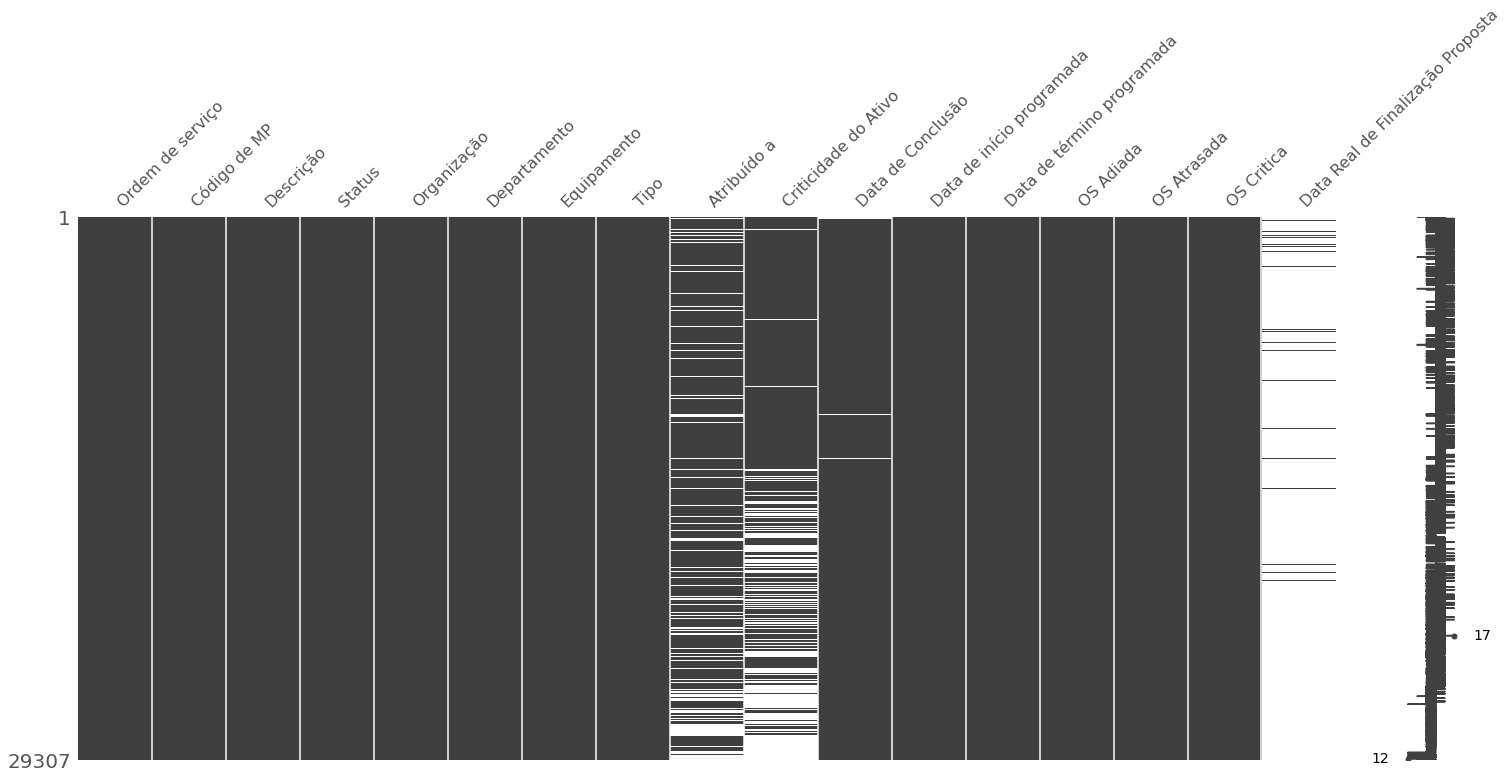

In [8]:
import missingno as msno
msno.matrix(OS)

Filling NaNs with - 

In [9]:
OS['Código de MP'] = OS['Código de MP'].fillna('-')
OS['Atribuído a'] = OS['Atribuído a'].fillna('-')
OS['Criticidade do Ativo'] = OS['Criticidade do Ativo'].fillna('-')
OS['Data de Conclusão'] = OS['Data de Conclusão'].fillna('-')
OS['Data Real de Finalização Proposta'] = OS['Data Real de Finalização Proposta'].fillna('-')

OS

,Ordem de serviço,Código de MP,Descrição,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta
19,10294737,SKO-UND-ELE-SMN-01,RONDA SEMANAL ELETRICA DO UNDER DECK,Aguardando Aprovação,SKO,MANU,DEC1001,Preventiva,-,*,-,29/05/2021,01/06/2021,NÃO,NÃO,NÃO,-
20,10294736,SKO-TOR-ELE-SMN-01,RONDA SEMANAL ELETRICA DA TORRE,Aguardando Aprovação,SKO,MANU,VLS1001,Preventiva,-,*,-,27/05/2021,30/05/2021,NÃO,NÃO,NÃO,-
22,10294585,SKO-PPL-AUT-SMN-01,RONDA SEMANAL DE AUTOMACAO,Aguardando Aprovação,SKO,MANU,PPL1001,Preventiva,-,-,-,29/05/2021,01/06/2021,NÃO,NÃO,NÃO,-
82,10294206,SKR-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Aprovada,SKR,MANU,DEC1001,Preventiva,131888,*,-,24/05/2021,27/05/2021,NÃO,NÃO,NÃO,-
99,10294151,SKO-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Em execução,SKO,MANU,DEC1001,Preventiva,126451,*,-,25/05/2021,28/05/2021,NÃO,NÃO,NÃO,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69836,2007763,LETG1603-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0007,Preventiva,99487,-,22/09/2015 07:58,30/09/2015,30/09/2015,NÃO,NÃO,NÃO,-
69837,2007761,LETG1602-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0006,Preventiva,99487,-,22/09/2015 07:58,30/09/2015,30/09/2015,NÃO,NÃO,NÃO,-
69838,2007759,LETG1601-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0005,Preventiva,-,-,29/09/2015 07:58,04/09/2015,20/09/2015,NÃO,NÃO,NÃO,-
69839,2007758,LPFM1501-MEN,Prev Mensal Integridade da rede hidr/Proteção ...,Fechada,SKN,MANU,MTR0001,Preventiva,21110,-,26/09/2015 06:59,25/09/2015,26/09/2015,NÃO,NÃO,NÃO,-


<AxesSubplot:>

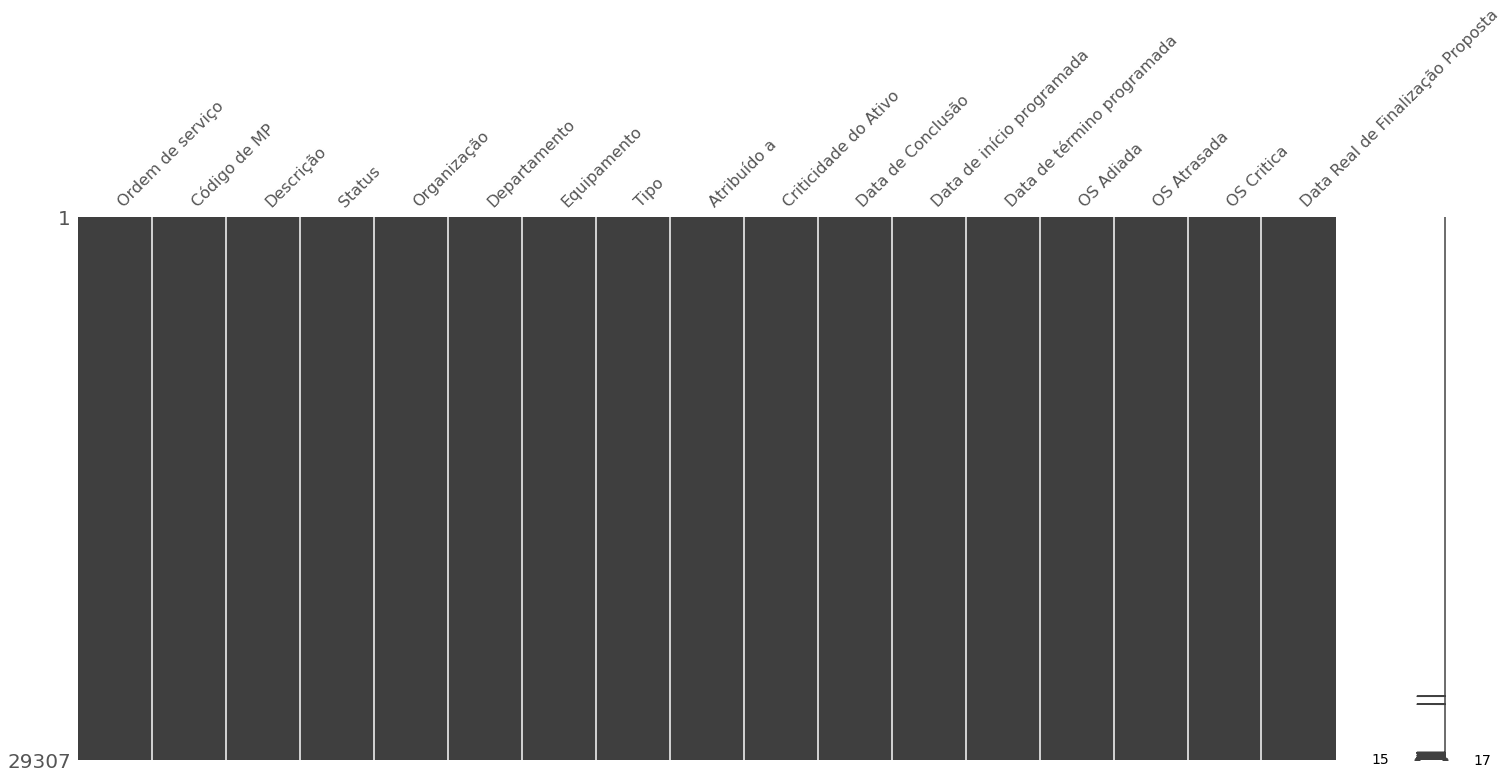

In [10]:
msno.matrix(OS)

Converting the columns 

In [11]:
OS['Data de término programada'] = pd.to_datetime(OS['Data de término programada'])
OS['Data de início programada'] = pd.to_datetime(OS['Data de início programada'])


In [12]:
OS

,Ordem de serviço,Código de MP,Descrição,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta
19,10294737,SKO-UND-ELE-SMN-01,RONDA SEMANAL ELETRICA DO UNDER DECK,Aguardando Aprovação,SKO,MANU,DEC1001,Preventiva,-,*,-,2021-05-29,2021-01-06,NÃO,NÃO,NÃO,-
20,10294736,SKO-TOR-ELE-SMN-01,RONDA SEMANAL ELETRICA DA TORRE,Aguardando Aprovação,SKO,MANU,VLS1001,Preventiva,-,*,-,2021-05-27,2021-05-30,NÃO,NÃO,NÃO,-
22,10294585,SKO-PPL-AUT-SMN-01,RONDA SEMANAL DE AUTOMACAO,Aguardando Aprovação,SKO,MANU,PPL1001,Preventiva,-,-,-,2021-05-29,2021-01-06,NÃO,NÃO,NÃO,-
82,10294206,SKR-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Aprovada,SKR,MANU,DEC1001,Preventiva,131888,*,-,2021-05-24,2021-05-27,NÃO,NÃO,NÃO,-
99,10294151,SKO-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Em execução,SKO,MANU,DEC1001,Preventiva,126451,*,-,2021-05-25,2021-05-28,NÃO,NÃO,NÃO,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69836,2007763,LETG1603-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0007,Preventiva,99487,-,22/09/2015 07:58,2015-09-30,2015-09-30,NÃO,NÃO,NÃO,-
69837,2007761,LETG1602-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0006,Preventiva,99487,-,22/09/2015 07:58,2015-09-30,2015-09-30,NÃO,NÃO,NÃO,-
69838,2007759,LETG1601-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0005,Preventiva,-,-,29/09/2015 07:58,2015-04-09,2015-09-20,NÃO,NÃO,NÃO,-
69839,2007758,LPFM1501-MEN,Prev Mensal Integridade da rede hidr/Proteção ...,Fechada,SKN,MANU,MTR0001,Preventiva,21110,-,26/09/2015 06:59,2015-09-25,2015-09-26,NÃO,NÃO,NÃO,-


Creating column with duration (end date - start date)

In [13]:
OS['Duração'] = OS['Data de término programada'] -  OS['Data de início programada']
OS

,Ordem de serviço,Código de MP,Descrição,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta,Duração
19,10294737,SKO-UND-ELE-SMN-01,RONDA SEMANAL ELETRICA DO UNDER DECK,Aguardando Aprovação,SKO,MANU,DEC1001,Preventiva,-,*,-,2021-05-29,2021-01-06,NÃO,NÃO,NÃO,-,-143 days
20,10294736,SKO-TOR-ELE-SMN-01,RONDA SEMANAL ELETRICA DA TORRE,Aguardando Aprovação,SKO,MANU,VLS1001,Preventiva,-,*,-,2021-05-27,2021-05-30,NÃO,NÃO,NÃO,-,3 days
22,10294585,SKO-PPL-AUT-SMN-01,RONDA SEMANAL DE AUTOMACAO,Aguardando Aprovação,SKO,MANU,PPL1001,Preventiva,-,-,-,2021-05-29,2021-01-06,NÃO,NÃO,NÃO,-,-143 days
82,10294206,SKR-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Aprovada,SKR,MANU,DEC1001,Preventiva,131888,*,-,2021-05-24,2021-05-27,NÃO,NÃO,NÃO,-,3 days
99,10294151,SKO-CON-ELE-SMN-01,RONDA SEMANAL ELETRICA DO CONVES,Em execução,SKO,MANU,DEC1001,Preventiva,126451,*,-,2021-05-25,2021-05-28,NÃO,NÃO,NÃO,-,3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69836,2007763,LETG1603-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0007,Preventiva,99487,-,22/09/2015 07:58,2015-09-30,2015-09-30,NÃO,NÃO,NÃO,-,0 days
69837,2007761,LETG1602-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0006,Preventiva,99487,-,22/09/2015 07:58,2015-09-30,2015-09-30,NÃO,NÃO,NÃO,-,0 days
69838,2007759,LETG1601-MEN,Prev Mensal Int. Estr./Proteção Anti-corrosiva...,Fechada,SKN,MANU,GUI0005,Preventiva,-,-,29/09/2015 07:58,2015-04-09,2015-09-20,NÃO,NÃO,NÃO,-,164 days
69839,2007758,LPFM1501-MEN,Prev Mensal Integridade da rede hidr/Proteção ...,Fechada,SKN,MANU,MTR0001,Preventiva,21110,-,26/09/2015 06:59,2015-09-25,2015-09-26,NÃO,NÃO,NÃO,-,1 days


Encoding the data

In [14]:
from sklearn.preprocessing import LabelEncoder
OS_encoded = OS.drop('Ordem de serviço',axis=1).drop('Descrição',axis=1)
le = LabelEncoder()
for col in OS_encoded.columns:
    OS_encoded.loc[:,col] = le.fit_transform(OS_encoded.loc[:,col].astype(str))
OS_encoded

,Código de MP,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta,Duração
19,2388,0,4,0,539,0,0,0,0,1826,1725,0,0,0,0,33
20,2358,0,4,0,1201,0,0,0,0,1824,1848,0,0,0,0,300
22,2296,0,4,0,993,0,0,1,0,1826,1725,0,0,0,0,33
82,2443,1,5,0,539,0,59,0,0,1821,1845,0,0,0,0,300
99,2185,5,4,0,539,0,42,0,0,1822,1846,0,0,0,0,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69836,490,6,3,0,771,0,99,1,16885,38,36,0,0,0,0,166
69837,487,6,3,0,770,0,99,1,16885,38,36,0,0,0,0,166
69838,484,6,3,0,769,0,0,1,21912,10,29,0,0,0,0,220
69839,544,6,3,0,939,0,67,1,19897,35,33,0,0,0,0,167


In [15]:
print(OS_encoded['OS Adiada'].value_counts())
print(OS_encoded['OS Atrasada'].value_counts())

0    28479
1      828
Name: OS Adiada, dtype: int64
0    28091
1     1216
Name: OS Atrasada, dtype: int64


In [16]:
OS_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29307 entries, 19 to 69840
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Código de MP                       29307 non-null  int32
 1   Status                             29307 non-null  int32
 2   Organização                        29307 non-null  int32
 3   Departamento                       29307 non-null  int32
 4   Equipamento                        29307 non-null  int32
 5   Tipo                               29307 non-null  int32
 6   Atribuído a                        29307 non-null  int32
 7   Criticidade do Ativo               29307 non-null  int32
 8   Data de Conclusão                  29307 non-null  int32
 9   Data de início programada          29307 non-null  int32
 10  Data de término programada         29307 non-null  int32
 11  OS Adiada                          29307 non-null  int32
 12  OS Atrasada      

We've filled all cells.The next step is to verify the target columns (OS adiada e OS atrasada).

In [17]:
# Verifying the values
print(OS['OS Adiada'].value_counts())
print(OS['OS Atrasada'].value_counts())

NÃO    28479
SIM      828
Name: OS Adiada, dtype: int64
NÃO    28091
SIM     1216
Name: OS Atrasada, dtype: int64


## 4 - Modelling

Creating the model to predict " OS Adiada"

In [34]:
# Split the data in train and test
X = OS_encoded.drop(['OS Adiada'],axis=1)
y = OS_encoded['OS Adiada']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

KNeighborsClassifier
Accuracy: 0.98516
Precision: 0.95402
Recall: 0.5
GaussianNB
Accuracy: 0.95121
Precision: 0.32143
Recall: 0.6506
LogisticRegression
Accuracy: 0.98158
Precision: 0.90278
Recall: 0.39157
DecisionTreeClassifier
Accuracy: 0.98976
Precision: 0.82317
Recall: 0.81325
RandomForestClassifier
Accuracy: 0.99266
Precision: 0.98425
Recall: 0.75301
GradientBoostingClassifier
Accuracy: 0.98994
Precision: 0.93496
Recall: 0.69277


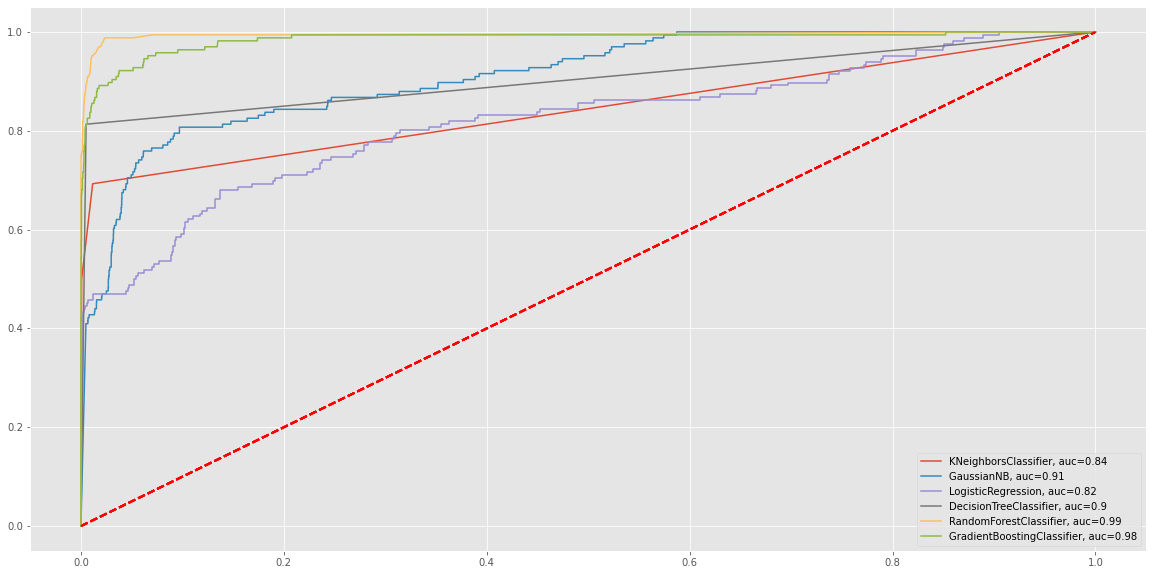

In [35]:
# import model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# creating a classifier list
classifiers = [
    KNeighborsClassifier(2),
    GaussianNB(),
    LogisticRegression(),
    #SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

# creating a function to run the pipeline
for clf in classifiers:
    # ajustando o modelo
    clf.fit(X_train, y_train)
    # armazenando o nome do modelo
    name = clf.__class__.__name__
    # imprimindo o nome do modelo
    print("="*30)
    print(name)
    # fazendo predições
    y_pred = clf.predict(X_test)
    # imprimindo as métricas
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(5))
    print("Precision:", metrics.precision_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    print("Recall:", metrics.recall_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    # plotting the ROC curve
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    plt.plot(fpr,tpr,label=name+", auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.legend(loc=4)

Creating the model to predict "OS atrasada"

In [36]:
# Split the data in train and test
X = OS_encoded.drop(['OS Atrasada'],axis=1)
y = OS_encoded['OS Atrasada']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

KNeighborsClassifier
Accuracy: 0.96691
Precision: 0.73786
Recall: 0.31276
GaussianNB
Accuracy: 0.95002
Precision: 0.39669
Recall: 0.39506
LogisticRegression
Accuracy: 0.95616
Precision: 0.29412
Recall: 0.04115
DecisionTreeClassifier
Accuracy: 0.96878
Precision: 0.61811
Recall: 0.64609
RandomForestClassifier
Accuracy: 0.97902
Precision: 0.92254
Recall: 0.53909
GradientBoostingClassifier
Accuracy: 0.96963
Precision: 0.79817
Recall: 0.35802


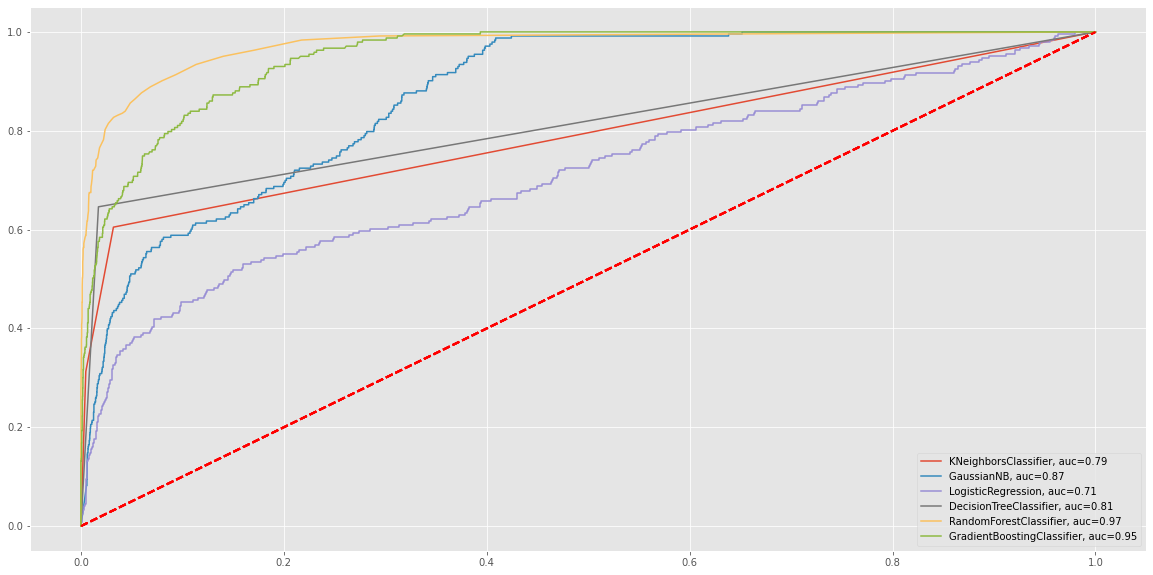

In [38]:
# import model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# creating a classifier list
classifiers = [
    KNeighborsClassifier(2),
    GaussianNB(),
    LogisticRegression(),
    #SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

# creating a function to run the pipeline
for clf in classifiers:
    # ajustando o modelo
    clf.fit(X_train, y_train)
    # armazenando o nome do modelo
    name = clf.__class__.__name__
    # imprimindo o nome do modelo
    print("="*30)
    print(name)
    # fazendo predições
    y_pred = clf.predict(X_test)
    # imprimindo as métricas
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(5))
    print("Precision:", metrics.precision_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    print("Recall:", metrics.recall_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    # plotting the ROC curve
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    plt.plot(fpr,tpr,label=name+", auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.legend(loc=4)

We need to improve our model. We'll balance the data to verify a improvement of the classifiers (it'll be used undersampling)

In [39]:
# balanceamento das classes por undersampling
OS_0 = OS_encoded[OS_encoded['OS Adiada']==0]
OS_1 = OS_encoded[OS_encoded['OS Adiada']==1]
OS_0 = OS_0.sample(n=828, replace=True)
OS_COPY = pd.concat([OS_0, OS_1], ignore_index=True)
OS_COPY

,Código de MP,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta,Duração
0,2228,6,4,0,795,0,66,8,1592,1667,1396,0,0,0,0,108
1,2922,6,2,0,860,0,54,8,10464,1537,1560,0,0,0,0,364
2,2432,6,5,0,358,0,59,0,5538,1783,1805,0,0,0,0,364
3,2603,1,5,0,803,0,0,3,0,1820,1725,0,0,0,0,26
4,2492,6,5,0,807,0,24,8,9572,1651,1555,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,2967,2,3,0,1169,0,77,0,3748,617,630,1,0,0,0,343
1652,212,2,3,0,775,0,77,0,3748,604,620,1,0,0,0,364
1653,181,2,3,0,532,0,90,6,3750,614,630,1,0,0,0,364
1654,2985,2,3,0,1200,0,77,1,3750,544,617,1,0,0,0,352


KNeighborsClassifier
Accuracy: 0.78916
Precision: 0.875
Recall: 0.6747
GaussianNB
Accuracy: 0.80723
Precision: 0.925
Recall: 0.66867
LogisticRegression
Accuracy: 0.77108
Precision: 0.82609
Recall: 0.68675
DecisionTreeClassifier
Accuracy: 0.91566
Precision: 0.90116
Recall: 0.93373
RandomForestClassifier
Accuracy: 0.94578
Precision: 0.94048
Recall: 0.95181
GradientBoostingClassifier
Accuracy: 0.93072
Precision: 0.93333
Recall: 0.92771


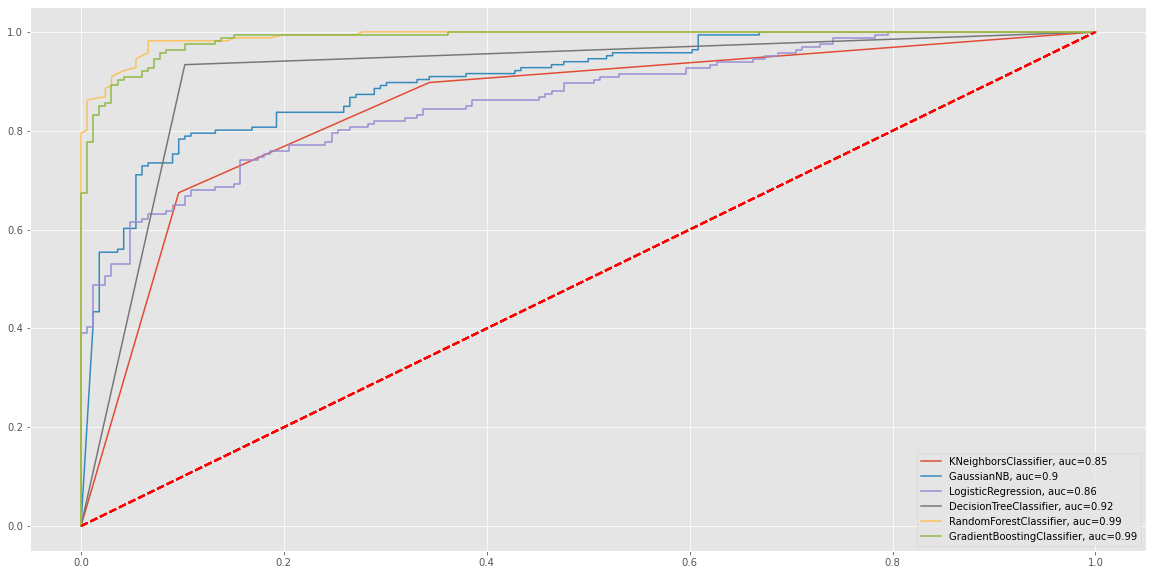

In [40]:
# Split the data in train and test
X = OS_COPY.drop(['OS Adiada'],axis=1)
y = OS_COPY['OS Adiada']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# import model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# creating a classifier list
classifiers = [
    KNeighborsClassifier(2),
    GaussianNB(),
    LogisticRegression(),
    #SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

# creating a function to run the pipeline
for clf in classifiers:
    # ajustando o modelo
    clf.fit(X_train, y_train)
    # armazenando o nome do modelo
    name = clf.__class__.__name__
    # imprimindo o nome do modelo
    print("="*30)
    print(name)
    # fazendo predições
    y_pred = clf.predict(X_test)
    # imprimindo as métricas
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(5))
    print("Precision:", metrics.precision_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    print("Recall:", metrics.recall_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    # plotting the ROC curve
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    plt.plot(fpr,tpr,label=name+", auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.legend(loc=4)

In [41]:
# balanceamento das classes por undersampling
OS_0 = OS_encoded[OS_encoded['OS Atrasada']==0]
OS_1 = OS_encoded[OS_encoded['OS Atrasada']==1]
OS_0 = OS_0.sample(n=1216, replace=True)
OS_COPY = pd.concat([OS_0, OS_1], ignore_index=True)
OS_COPY

,Código de MP,Status,Organização,Departamento,Equipamento,Tipo,Atribuído a,Criticidade do Ativo,Data de Conclusão,Data de início programada,Data de término programada,OS Adiada,OS Atrasada,OS Critica,Data Real de Finalização Proposta,Duração
0,1450,6,1,0,530,0,7,9,4679,1746,1788,0,0,0,0,293
1,2484,6,5,0,1072,0,76,0,9564,1681,1635,0,0,0,0,147
2,1789,6,2,0,624,0,0,1,18240,1486,1589,0,0,0,0,363
3,1727,6,2,0,354,0,36,8,4475,1685,1679,0,0,0,0,63
4,2492,6,5,0,798,0,23,8,8524,1869,1762,0,0,0,0,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,1416,6,1,0,274,0,0,6,22620,1376,1360,1,1,0,11,118
2428,1722,6,2,0,285,0,0,1,10092,1361,1404,1,1,0,0,293
2429,1720,6,2,0,276,0,0,1,12906,1530,1515,1,1,0,303,113
2430,1720,6,2,0,275,0,0,6,12907,1530,1515,1,1,0,303,113


KNeighborsClassifier
Accuracy: 0.78234
Precision: 0.83415
Recall: 0.7037
GaussianNB
Accuracy: 0.72074
Precision: 0.73362
Recall: 0.69136
LogisticRegression
Accuracy: 0.71047
Precision: 0.7125
Recall: 0.7037
DecisionTreeClassifier
Accuracy: 0.81314
Precision: 0.80159
Recall: 0.83128
RandomForestClassifier
Accuracy: 0.87064
Precision: 0.83835
Recall: 0.9177
GradientBoostingClassifier
Accuracy: 0.85216
Precision: 0.80427
Recall: 0.93004


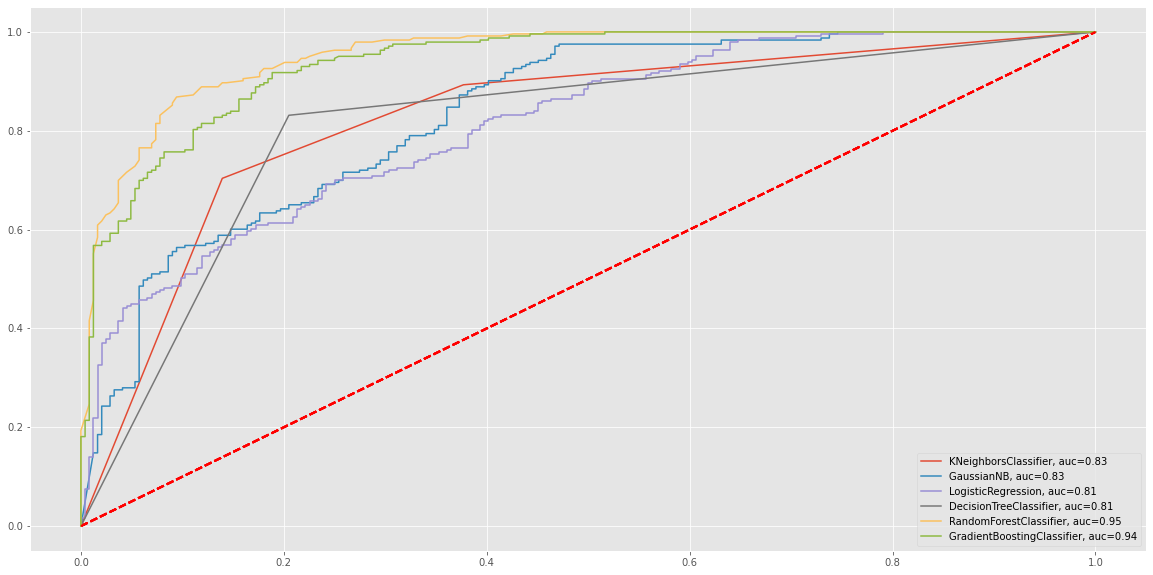

In [42]:
# Split the data in train and test
X = OS_COPY.drop(['OS Atrasada'],axis=1)
y = OS_COPY['OS Atrasada']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# import model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# creating a classifier list
classifiers = [
    KNeighborsClassifier(2),
    GaussianNB(),
    LogisticRegression(),
    #SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

# creating a function to run the pipeline
for clf in classifiers:
    # ajustando o modelo
    clf.fit(X_train, y_train)
    # saving the model name
    name = clf.__class__.__name__
    # printing the model name
    print("="*30)
    print(name)
    # making predictions
    y_pred = clf.predict(X_test)
    # printing the metrics
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(5))
    print("Precision:", metrics.precision_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    print("Recall:", metrics.recall_score(y_test, y_pred,average='binary',pos_label=1).round(5))
    # plotting the ROC curve
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba).round(2)
    plt.plot(fpr,tpr,label=name+", auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.legend(loc=4)

## 5 - API and Deployment

In [3]:
import requests
import json